In [1]:
#initialize H2O Environment

import h2o
h2o.init(max_mem_size_GB = 2)

H2O cluster uptime:,6 minutes 24 seconds 805 milliseconds
H2O cluster version:,3.7.0.99999
H2O cluster name:,Kevin
H2O cluster total nodes:,1
H2O cluster total memory:,1.78 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

spiral = h2o.upload_file("../data/spiral.csv")
grid  = h2o.upload_file("../data/grid.csv")




Parse Progress: [##################################################] 100%

Parse Progress: [##################################################] 100%


In [3]:
X = spiral.col_names[0:2]
y = spiral.col_names[2]
dl_model = H2ODeepLearningEstimator(epochs=1000)
dl_model.train(X, y, spiral)

gbm_model = H2OGradientBoostingEstimator()
gbm_model.train(X, y, spiral)

drf_model = H2ORandomForestEstimator()
drf_model.train(X, y, spiral)

glm_model = H2OGeneralizedLinearEstimator(family="binomial")
glm_model.train(X, y, spiral)

models = [dl_model, gbm_model, drf_model, glm_model]
m_names = ["Deep Learning", "Gradient Boosted", "Distributed Random Forest", "Generalized Linear"]



deeplearning Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%


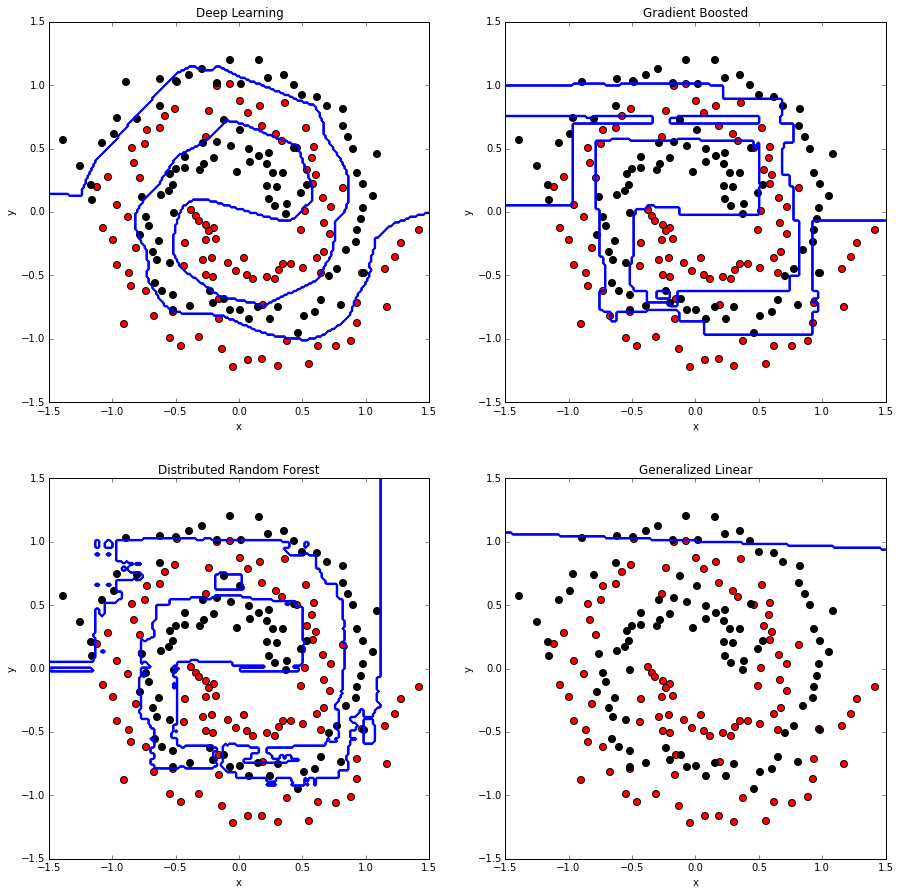

In [23]:
# for i in xrange(4):
#     pred = models[i].predict(grid)

spiral_df = spiral.as_data_frame(use_pandas=True)
grid_df = grid.as_data_frame(use_pandas=True)
grid_x, grid_y = grid_df.x.reshape(201,201), grid_df.y.reshape(201,201)
spiral_r = spiral_df[spiral_df.color == "Red"]
spiral_k = spiral_df[spiral_df.color == "Black"]


spiral_xr, spiral_yr = spiral_r[spiral_r.columns[0]], spiral_r[spiral_r.columns[1]]

spiral_xk, spiral_yk = spiral_k[spiral_k.columns[0]], spiral_k[spiral_k.columns[1]]

fig, ax = plt.subplots(2,2, figsize=(15,15))
                 # the first subplot in the first figure
markersize_ = 7**2 #markersize is given as an area
for k, subplot in enumerate(ax.flatten()):
    subplot.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
    subplot.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
    subplot.axis([-1.5, 1.5, -1.5, 1.5])
    subplot.set_title(m_names[k])
    subplot.set_xlabel('x')
    subplot.set_ylabel('y')
    pred_z = models[k].predict(grid).as_data_frame(True)
    subplot.contour(grid_x, grid_y, (pred_z['predict'] == 'Black').astype(np.int).reshape(201,201), colors='b')
    
# plt.subplot(224)             # the second subplot in the first figure
# plt.plot([4, 5, 6]);

In [ ]:
cov_df = h2o.upload_file("../data/covtype.full.csv")